# [Computational Social Science] Project 4: Unsupervised Learning
Group members: Jose Aveldanes, Lawrence Liu & Alex Ramiller

Date: 12/18/20

## Data Description and Preprocessing

For this project, we explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [23]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import math 

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

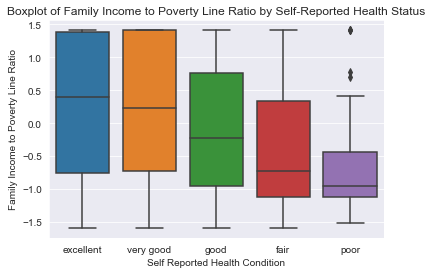

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

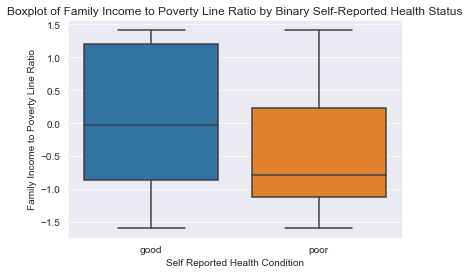

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

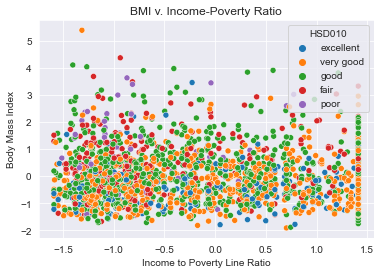

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled_X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train and Discuss Number of Components

When choosing the number of components, we are effectively trading off between interpretability and how much variance we want our components to explain. Including more components will account for more variation in the data, but will make the model more complex. 

(Code for graphs below adapted from: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components)

Below, we graph the variation explained when choosing n components, where n = [1,241]. First, let's take a look at how much variation is accounted for by each possible component.

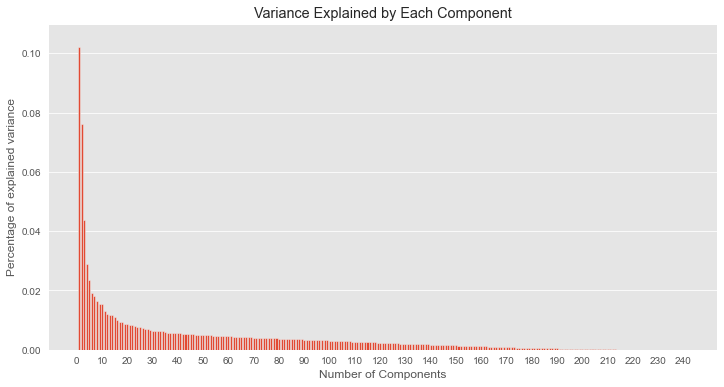

In [8]:
pca = PCA().fit(nhanes_scaled_X)

##Line Plot

#% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
plt.style.use('ggplot')

fig, ax = plt.subplots()
xi = np.arange(1, len(nhanes_scaled_X.columns) + 1, step=1)
y = pca.explained_variance_ratio_

plt.ylim(0.0,0.11)
plt.bar(xi, y)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 241, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Percentage of explained variance')
plt.title('Variance Explained by Each Component')

ax.grid(axis='x')
plt.show()

Next, let's plot the components again with cumulative variance along the y-axis. 

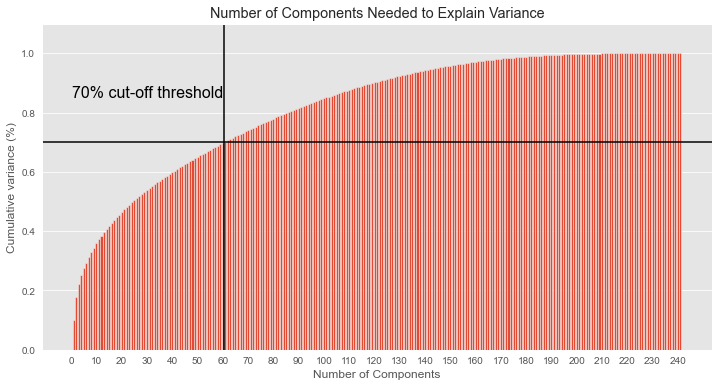

In [20]:
fig, ax = plt.subplots()
xi = np.arange(1, len(nhanes_scaled_X.columns) + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
cutoff = 0.7


plt.ylim(0.0,1.1)
plt.bar(xi, y)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 241, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('Number of Components Needed to Explain Variance')

plt.axhline(y=cutoff, color='black', linestyle='-')
plt.text(0.5, 0.85, '70% cut-off threshold', color = 'black', fontsize=16)

plt.axvline(x = np.interp(cutoff, y, xi), color = 'black', linestyle = '-')

ax.grid(axis='x')
plt.show()

Let's see how many components we would need to include to account for 70% of the variance in the dataset. With that as the threshhold, it looks like we should reduce the number of features from 241 to about 60. Let's see where the plot intersects with y = 0.7.

In [36]:
n_components = math.ceil(np.interp(cutoff, y, xi))
print(n_components)

61


Since we would like for the components to account for at least 70% of the variance, we train the model with 61 components. 

Why 70%? Note again that this choice of threshhold is very contextual. Based on the plots above, it looks like the amount of information added by each component after the first 10 is quite marginal. At the same time, we would hope that the components would together account for a significant proportion of the variance. 70% seemed like a cutoff that would allow for a significant reduction in features without sacrificing too much information. We acknowledge, however, that this is a key decision point that may vary from researcher to researcher.

In [28]:
##train PCA with 61 components
pca = PCA(n_components=n_components) 
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_X)

### How many components will you use to fit a supervised learning model?

We will use 61 components to fit a supervised learning model. By reducing the number of features in our subsequent supervised learning models from 241 to 61, we save on computational processing time and benefit from a less complex model. Given that these 61 components still account for slightly more than 70% of the variance in our dataset, we gain these benefits without sacrificing too much information in the unaccounted-for variance.

### 2D Scatterplot of the first two components

In [29]:
#grab first two colums of the principal components array
pca_df = pd.DataFrame(data = principalComponents_nhanes[:,:2], 
                      columns = ['principal component 1', 'principal component 2'])

In [30]:
#Add ID in as index
pca_df["SEQN"] = seqn
pca_df = pca_df.set_index('SEQN')

pca_df.head()

,principal component 1,principal component 2
SEQN,,
73568,9.527808,-0.816232
73576,-5.838347,-3.692562
73579,-0.719452,-2.573201
73581,3.533628,-2.576984
73584,-6.872091,-4.194241


<Figure size 432x288 with 0 Axes>

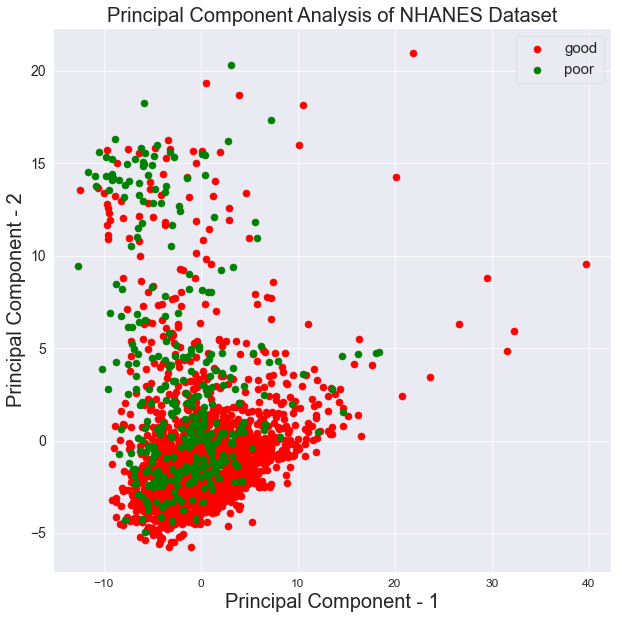

In [31]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

Summarizing the data with only principal components 1 and 2 does not do a good job of separating "good" self-reported health conditions from "poor" self-reported health conditions. This is not unsurprising given that the first two components only account for about 18% of the cumulative variance in the data.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We selected the K-Means clustering method, which provides a straightforward way to identify clusters in the data based on a pre-specified number of clusters. This method is selected over hierarchical clustering both because it is computationally straightforward and because 

### Cluster nhanes

In [70]:
## Finding the "elbow"
inertias = []

for k in range(1, 10):
    kmeans_test = KMeans(n_clusters=k, max_iter=300).fit(nhanes_scaled_X)
    inertias.append(kmeans_test.inertia_)

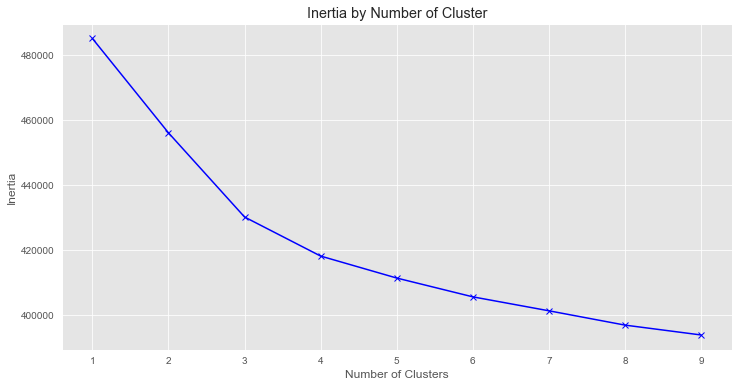

In [71]:
plt.plot(range(1, 10), inertias, 'bx-') 
plt.xlabel('Number of Clusters') 
plt.ylabel('Inertia') 
plt.title('Inertia by Number of Cluster') 
plt.show()

Using "inertia", which is a measure of the sum of squared distances of observations from their assigned cluster centers, provides a good indication of the point at which there are diminishing marginal returns to the additional variation explained by each cluster. For this dataset, the decline in the value of inertia markedly decreases after 3 clusters. Therefore, our K-means model will use 3 as its "k" hyperparameter.

In [72]:
kmeans = KMeans(n_clusters=3, max_iter=300).fit(nhanes_scaled_X)
nhanes_scaled_X["Cluster"] = kmeans.labels_

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

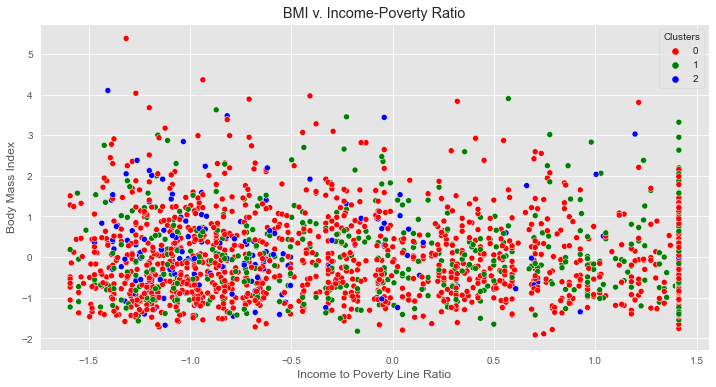

In [73]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "Cluster", palette = ['r', 'g', 'b'], data = nhanes_scaled_X)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

The K-means clusters based on all (non-target) variables in the NHANES data do not seem to be strongly clustered along the relationship between BMI and the Income-Poverty Ratio; rather the distribution of points within each cluster appears fairly random along these two dimensions.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [74]:
kmeans_pca = KMeans(n_clusters=3, max_iter=300).fit(pca_df)
pca_df["Clusters"] = kmeans_pca.labels_

<Figure size 864x432 with 0 Axes>

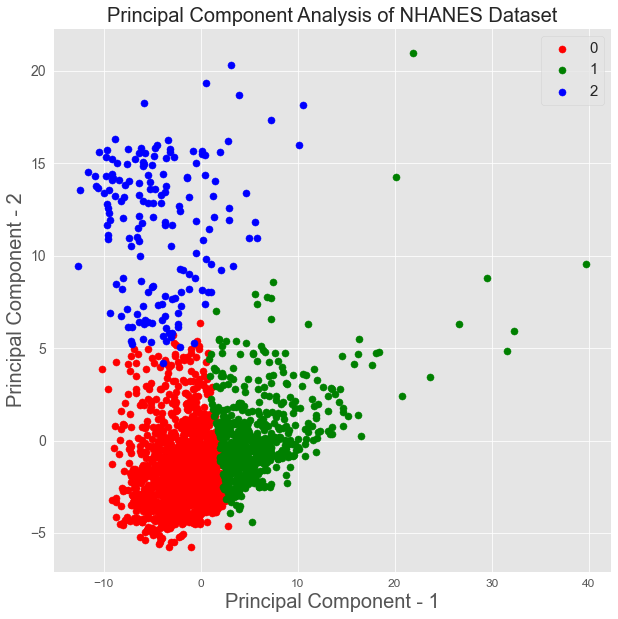

In [75]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled_X['Clusters'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

Clusters based on the two principal components from the preceding PCA identify three distinct clusters that are nearly perfectly separated: one cluster with high values for PC-1 and low values for PC-2, one cluster with high values for PC-2 and low values for PC-1, and one cluster with low values for both principal components.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
y = ... # either hsd010 or hsd010_binary
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
import keras
num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
model = Sequential()

model.add(
    Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...)
)

model.add(
    Dense(..., kernel_initializer= ..., activation= ...)
)

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
## Your Answer Here